1. Clone repos and install requirements

In [1]:
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'latent-diffusion'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 341 (delta 115), reused 110 (delta 110), pack-reused 184
Receiving objects: 100% (341/341), 28.69 MiB | 32.21 MiB/s, done.
Resolving deltas: 100% (148/148), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 33.91 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
# /taming-transformers/taming/data/utils.py
# Comment 'from torch._six import string_classes'

!pip install -e ./taming-transformers
!pip install ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')

from taming.models import vqgan # checking correct import from taming

Obtaining file:///content/taming-transformers
  Preparing metadata (setup.py) ... done
  Running setup.py develop for taming-transformers


2. Define the Task (currently only superresolution is available, other tasks are coming soon)



In [3]:
%cd latent-diffusion
import ipywidgets as widgets
from IPython.display import display

mode = widgets.Select(options=['superresolution'],
    value='superresolution', description='Task:')
display(mode)

/content/latent-diffusion


Select(description='Task:', options=('superresolution',), value='superresolution')

3. Download model checkpoint ( takes ~ 3 Min) and load model


In [5]:
# /latent-diffusion/ldm/models/diffusion/ddpm.py
# Change 'pytorch_lightning.utilities.distributed' -> 'pytorch_lightning.utilities.rank_zero'

from notebook_helpers import get_model
model = get_model(mode.value)

Using downloaded and verified file: logs/diffusion/superresolution_bsr/configs/project.yaml/?dl=1
Using downloaded and verified file: logs/diffusion/superresolution_bsr/checkpoints/last.ckpt/?dl=1
Loading model from logs/diffusion/superresolution_bsr/checkpoints/last.ckpt/?dl=1
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


4. Optional step: Upload your own conditioning image for superresolution (height and width have to take values in [128, 192, 256])

In [6]:
from notebook_helpers import get_custom_cond
get_custom_cond(mode.value)

Saving 04-downsampled.jpg to 04-downsampled.jpg


4. Select conditioning from available examples or the uploaded custom conditioning

In [7]:
from notebook_helpers import get_cond_options, get_cond
dir, options = get_cond_options(mode.value)
cond_choice = widgets.RadioButtons(
        options=options,
        description='Select conditioning:',
        disabled=False
    )
display(cond_choice)

RadioButtons(description='Select conditioning:', options=('custom_04-downsampled.jpg', 'sample_0.jpg'), value=…

5. Run Model

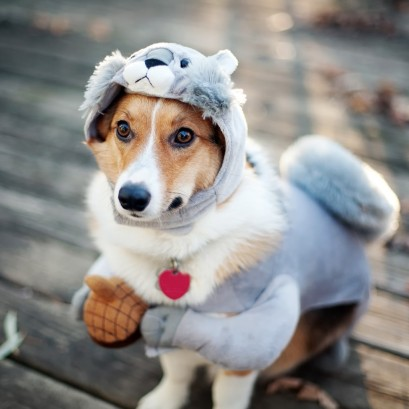

Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 100
Data shape for DDIM sampling is (1, 3, 409, 409), eta 1.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Plotting: Restored training weights


In [8]:
from notebook_helpers import run
from torchvision.io import ImageReadMode, read_image, write_png
import os
custom_steps = 100
cond_choice_path = os.path.join(dir, cond_choice.value)

logs = run(model["model"], cond_choice_path, mode.value, custom_steps)

6. Display Sample

(1, 1636, 1636, 3)


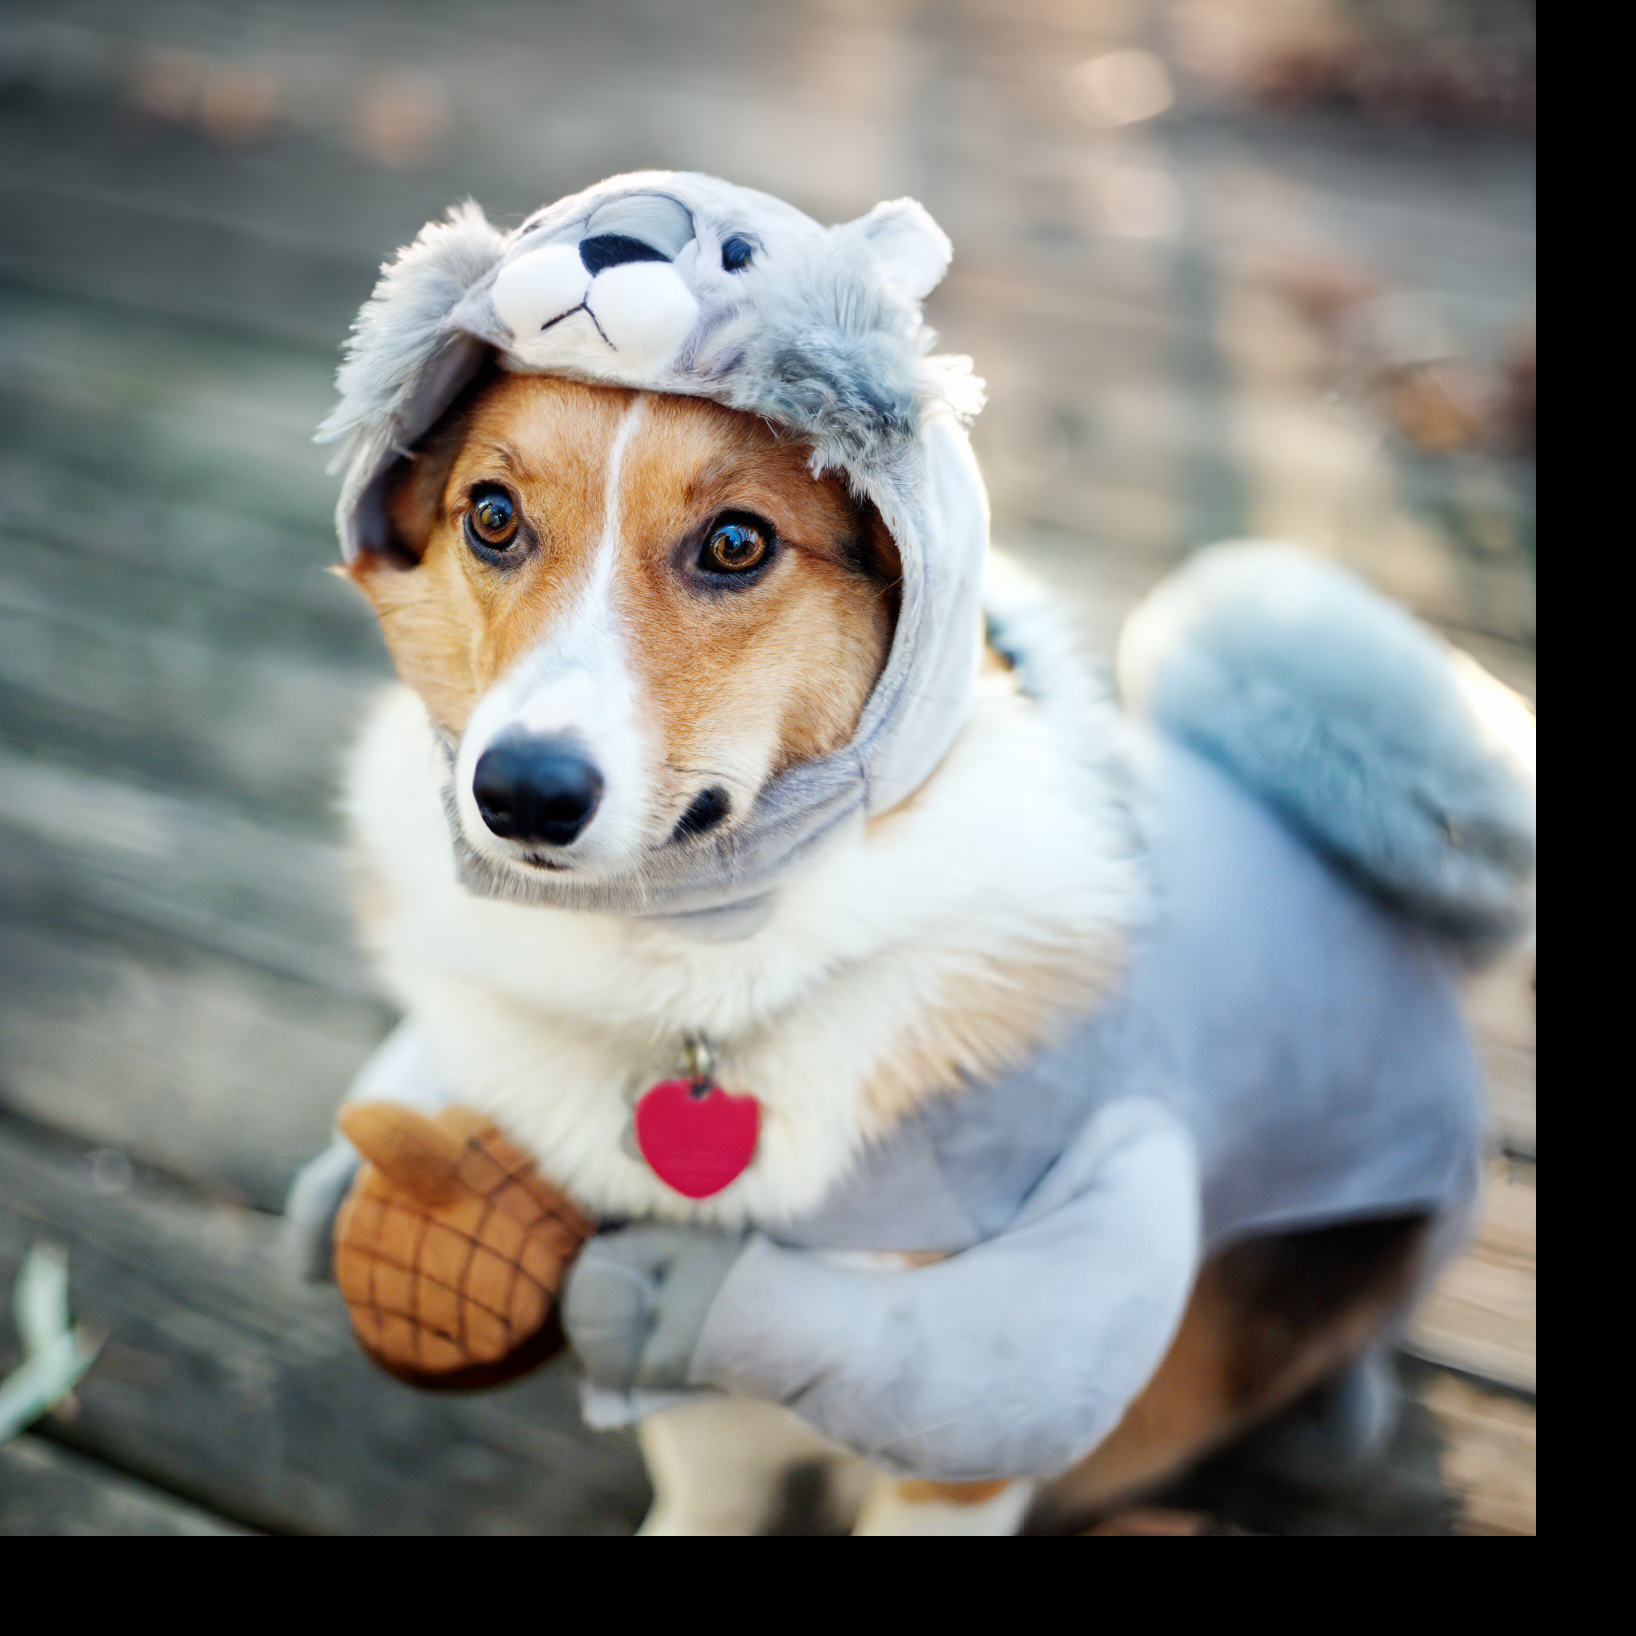

In [9]:
import torch
import numpy as np
import IPython.display as d
from PIL import Image

sample = logs["sample"]
sample = sample.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
print(sample.shape)
a = Image.fromarray(sample[0])
display(a)
